In [54]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [55]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [56]:
(train_img0,train_class0),(test_img0,test_class0)=tf.keras.datasets.mnist.load_data()

train_img=train_img0[(train_class0==8)]
train_img2=train_img0[(train_class0==7)]
test_img=test_img0[(test_class0==8)]
test_img2=test_img0[(test_class0==7)]

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255
train_img2=train_img2.reshape(train_img2.shape[0],height,width,1).astype('float32')
train_img2/=255

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255
test_img2=test_img2.reshape(test_img2.shape[0],height,width,1).astype('float32')
test_img2/=255

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=32

num=60000
comps=2

beta=0.1

In [57]:
from keras.preprocessing.image import ImageDataGenerator
def blender(data,data2,file,num=60000):

    datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0,height_shift_range=0,
                                 shear_range=0.0,zoom_range=[1.2,1.5])
    datagen2=ImageDataGenerator(rotation_range=20,width_shift_range=0.5,height_shift_range=0.5,
                                 shear_range=0.1,zoom_range=[1.2,1.5])

    gen=datagen.flow(data,None,batch_size=1)
    gen2=datagen2.flow(data2,None,batch_size=1)

    components=np.array([[gen.next()[0, ..., 0] for j in range(num)],[gen2.next()[0, ..., 0] for j in range(num)]])
    blended=components.sum(axis=0)
    together=[blended,components[0],components[1]]
    np.save(file,together)
    
blender(train_img,train_img2,'blended_set')
blender(test_img,test_img2,'blended_set_test')

In [58]:
together=np.load('blended_set.npy')
blended,components=together[0],np.array((together[1],together[2]))
blended.shape,components.shape

validation=np.load('blended_set_test.npy')
blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
blended_v.shape,components_v.shape

((60000, 28, 28), (2, 60000, 28, 28))

In [59]:
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

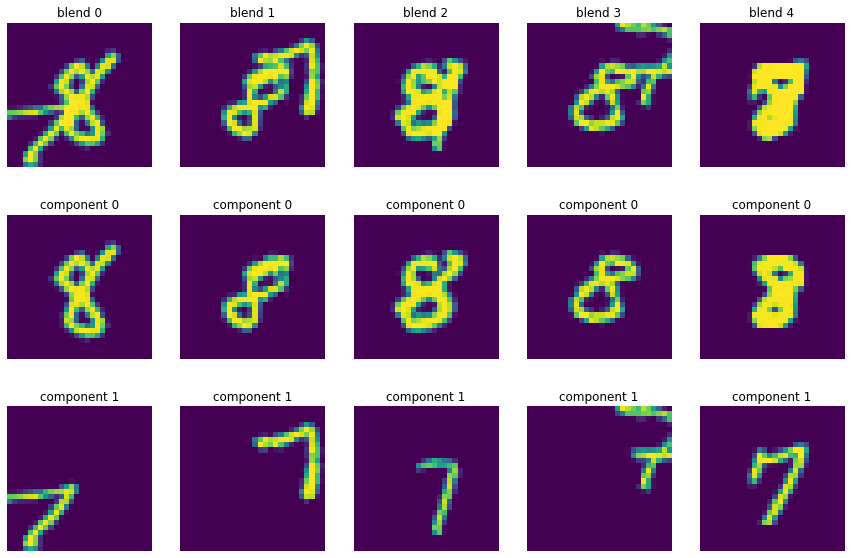

In [60]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [61]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [62]:
def decoder(x):
    #x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [63]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [64]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [65]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 3136)         0           conv2d_9[0][0]                   
______________________________________________________________________________________

In [66]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_21 (Functional)   (None, 32)                219584    
_________________________________________________________________
functional_23 (Functional)   (None, 28, 28, 1)         159169    
Total params: 378,753
Trainable params: 378,753
Non-trainable params: 0
_________________________________________________________________


In [67]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [68]:
history=vae.fit(components[0],verbose=1,epochs=5,batch_size=batch_size)

Epoch 1/5
600/600 [==============================] - 30s 50ms/step - loss: 8.5373 - mse_loss: 8.2472 - kl_loss: 0.2900
Epoch 2/5
600/600 [==============================] - 30s 49ms/step - loss: 2.5478 - mse_loss: 2.2297 - kl_loss: 0.3182
Epoch 3/5
600/600 [==============================] - 29s 49ms/step - loss: 2.0840 - mse_loss: 1.7673 - kl_loss: 0.3167
Epoch 4/5
600/600 [==============================] - 30s 50ms/step - loss: 1.8658 - mse_loss: 1.5498 - kl_loss: 0.3160
Epoch 5/5
600/600 [==============================] - 31s 51ms/step - loss: 1.7409 - mse_loss: 1.4252 - kl_loss: 0.3157


In [69]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(2, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
    return idx

[24 17 19 20 14]


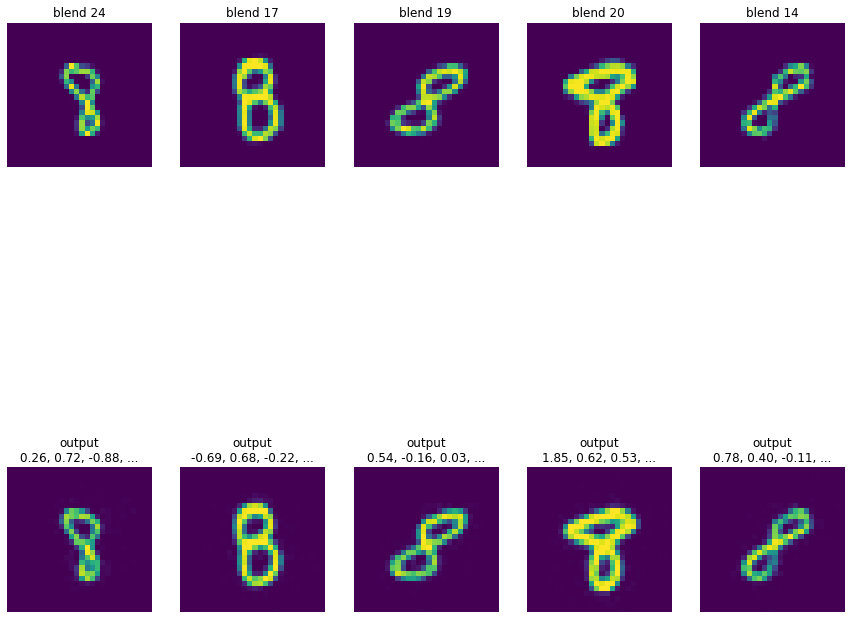

In [70]:
chosen=summary_plot(n,components[0],decode)

In [71]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [72]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_10[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 3136)         0           conv2d_11[0][0]                  
______________________________________________________________________________________

In [73]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_27 (Functional)      (None, 32)           219584      input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_23 (Functional)      (None, 28, 28, 1)    159169      functional_27[0][0]              
Total params: 378,753
Trainable params: 219,584
Non-trainable params: 159,169
________

In [74]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [75]:
history=vae.fit(together,verbose=1,epochs=5,batch_size=batch_size,validation_data=together_v)

Epoch 1/5
600/600 [==============================] - 31s 52ms/step - loss: 8.9320 - mse_loss: 8.6238 - kl_loss: 0.3082 - val_loss: 6.0724 - val_mse_loss: 5.7531 - val_kl_loss: 0.3193
Epoch 2/5
600/600 [==============================] - 31s 51ms/step - loss: 5.5239 - mse_loss: 5.2136 - kl_loss: 0.3103 - val_loss: 5.2730 - val_mse_loss: 4.9600 - val_kl_loss: 0.3130
Epoch 3/5
600/600 [==============================] - 30s 51ms/step - loss: 4.9839 - mse_loss: 4.6731 - kl_loss: 0.3108 - val_loss: 4.9219 - val_mse_loss: 4.6128 - val_kl_loss: 0.3091
Epoch 4/5
600/600 [==============================] - 30s 51ms/step - loss: 4.6813 - mse_loss: 4.3711 - kl_loss: 0.3102 - val_loss: 4.7134 - val_mse_loss: 4.3937 - val_kl_loss: 0.3196
Epoch 5/5
600/600 [==============================] - 30s 51ms/step - loss: 4.4613 - mse_loss: 4.1508 - kl_loss: 0.3105 - val_loss: 4.5325 - val_mse_loss: 4.2205 - val_kl_loss: 0.3119


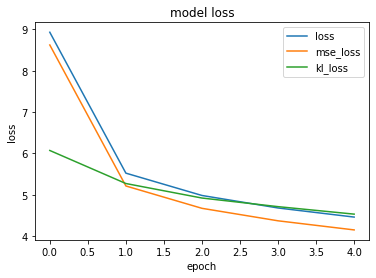

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['mse_loss'])
#plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse_loss','kl_loss','val_loss'])

In [76]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(4, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
    return idx

[15281 21435 44536 13518 47529]


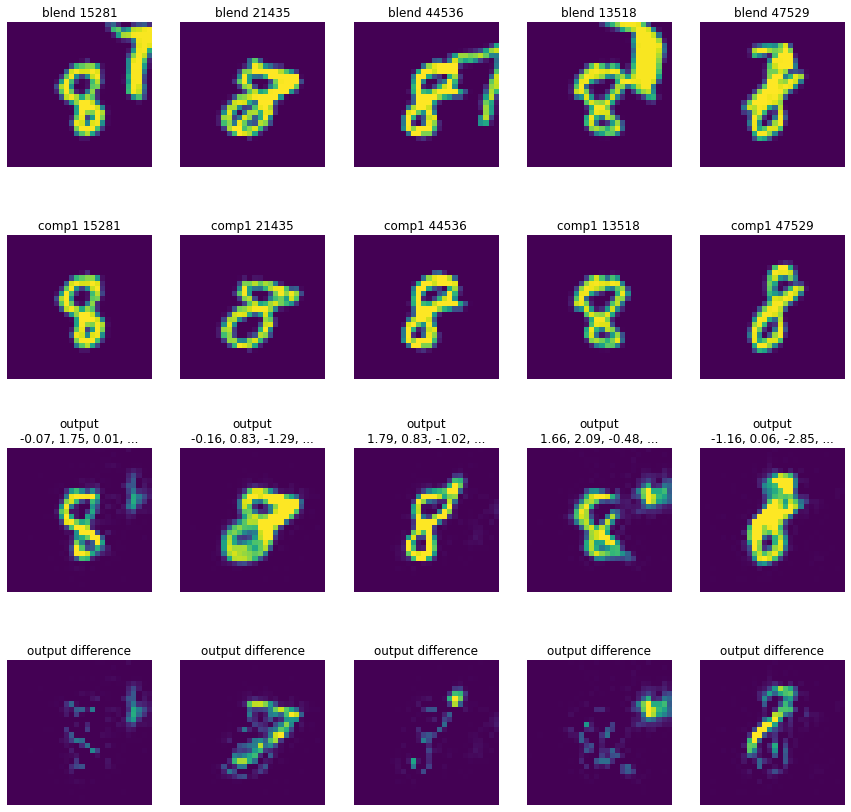

In [77]:
chosen=summary_plot(n,together,decode)

In [126]:
together_v=[blended_v,components_v[0]]

ite=0

input_img=blended_v[ite:ite+1]
compc=components_v[0,ite:ite+1]
#z=encode.predict(input_img)
#output_img=decode.predict([z,compc])

#mse_loss_predict=tf.reduce_mean(mse(compc,output_img)*height*width)

eval=vae.evaluate(together_v,verbose=1,batch_size=batch_size,return_dict=True)
eval.items()

600/600 [==============================] - 12s 20ms/step - loss: 4.5328 - mse_loss: 4.2209 - kl_loss: 0.3119


AttributeError: 'dict' object has no attribute 'history'